In [1]:
!pip install kaggle

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mahmoudelhout","key":"f73458926c39d33cab416ea9c51f8407"}'}

In [4]:
!mkdir -p ~/.kaggle

In [5]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle competitions download -c elo-merchant-category-recommendation

In [7]:
!unzip elo-merchant-category-recommendation.zip

Archive:  elo-merchant-category-recommendation.zip
  inflating: Data Dictionary.xlsx    
  inflating: Data_Dictionary.xlsx    
  inflating: historical_transactions.csv  
  inflating: merchants.csv           
  inflating: new_merchant_transactions.csv  
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


train.csv contains card_ids and information about the card itself - the first month the card was active, etc. train.csv also contains the target.



# <font color='red'> **1- Importing Libraries & Functions**

In [8]:
from datetime import datetime

import sys
sys.path.append('/content/drive/MyDrive/Final_Project_ELO_Merchant/')
from Helpers import *

# <font color='red'> **2- Reading Dataset**

In [9]:
df=pd.read_csv('/content/train.csv')

### <font color='blue'>Data Dictionary file</b>


In [10]:
data_dic_train=pd.read_excel('/content/Data_Dictionary.xlsx',sheet_name='train')
data_dic_train[2:]

,train.csv,Unnamed: 1
2,card_id,Unique card identifier
3,first_active_month,"'YYYY-MM', month of first purchase"
4,feature_1,Anonymized card categorical feature
5,feature_2,Anonymized card categorical feature
6,feature_3,Anonymized card categorical feature
7,target,Loyalty numerical score calculated 2 months af...


In [11]:
print(df.shape)
print(df.head(3))

(201917, 6)
  first_active_month          card_id  feature_1  feature_2  feature_3  target
0            2017-06  C_ID_92a2005557          5          2          1  -0.820
1            2017-01  C_ID_3d0044924f          4          1          0   0.393
2            2016-08  C_ID_d639edf6cd          2          2          0   0.688


# <font color='red'> **3- Data Cleaning**

### <font color='blue'>Checking for duplicates and nulls ,datatypes</b>###

In [12]:
df.duplicated().sum()

np.int64(0)

In [13]:
CheckMissing(df)

Dataset has No Nulls


0

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201917 entries, 0 to 201916
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   first_active_month  201917 non-null  object 
 1   card_id             201917 non-null  object 
 2   feature_1           201917 non-null  int64  
 3   feature_2           201917 non-null  int64  
 4   feature_3           201917 non-null  int64  
 5   target              201917 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 9.2+ MB


first_active_month should be casted as DataTime , we can make some feature engineering

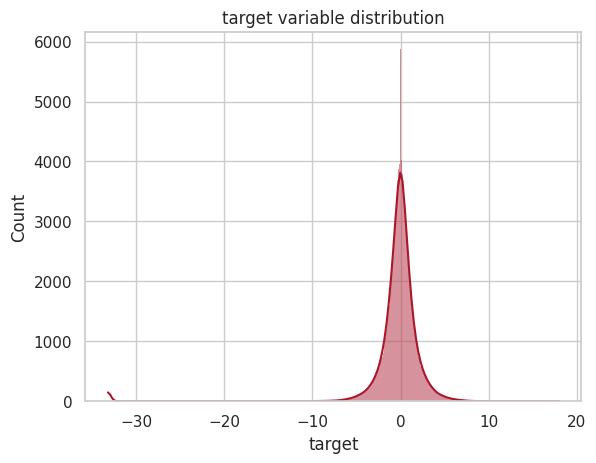

In [15]:
sns.histplot(data=df,x='target',kde=True)
plt.title('target variable distribution')
plt.show();

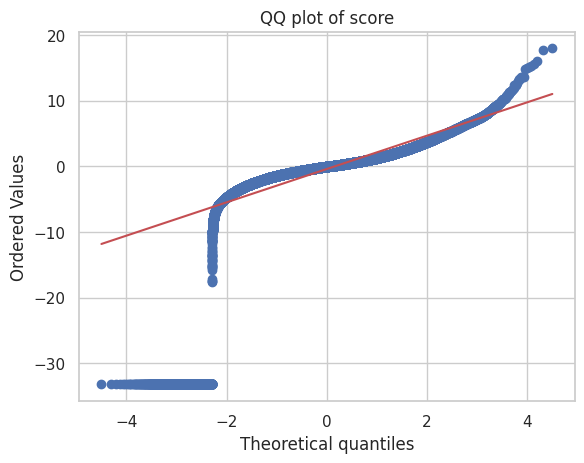

In [16]:
# Q-Q plot
stats.probplot(df['target'],plot=plt,dist='norm')
plt.title('QQ plot of score')
plt.show();

- Instead of forming a straight diagonal line, the points form an S-shape.
- The points at the lower end deviate significantly below the line.Which suggests the data has extreme low values (left-skewed) or outliers in the lower tail.
- The points at the upper end curve above the line but not much as the lower end . Which might indicates  high values (right-skewed) or heavy-tailed behavior.
- The points at the extreme left (below -30) seem clustered and flat. indicates a large number of repeated extreme values. Lets analyze these points further




In [17]:
below_30=df[df['target']<-30]
below_30_perc=below_30.shape[0]/df.shape[0]*100
print(below_30_perc)

1.0930233709890698


1.09% is Small, But is it Negligible ? need a closer look.



In [18]:
# Separate outliers
# Calculate the mean and standard deviation of each group
df_no_outliers, df_outliers = SeparateOutliers(df, 'target')

 Separated 15397 outliers from 'target'

**Statistics for Non-Outliers**:
   - Mean: -0.032
   - Standard Deviation: 1.233

 **Statistics for Outliers**:
   - Mean: -4.773
   - Standard Deviation: 12.460


- The large standard deviation in the outliers suggests that these points are highly scattered and may not belong to the same distribution as the majority of the data.
- Since the outliers have a strongly negative mean, they might be extreme negative values rather than just random noise.


In [19]:
outlier_dict = OutliersInfo(df, ['target'])


target
-----------------------------------
Number of outlier samples produced by IQR: 15397
0% percentile value is -33.219
1% percentile value is -33.219
98% percentile value is 3.878
99% percentile value is 4.813
100% percentile value is 17.965

	- Number of values less than -33.219: 0
	- Number of values greater than 4.813: 2020


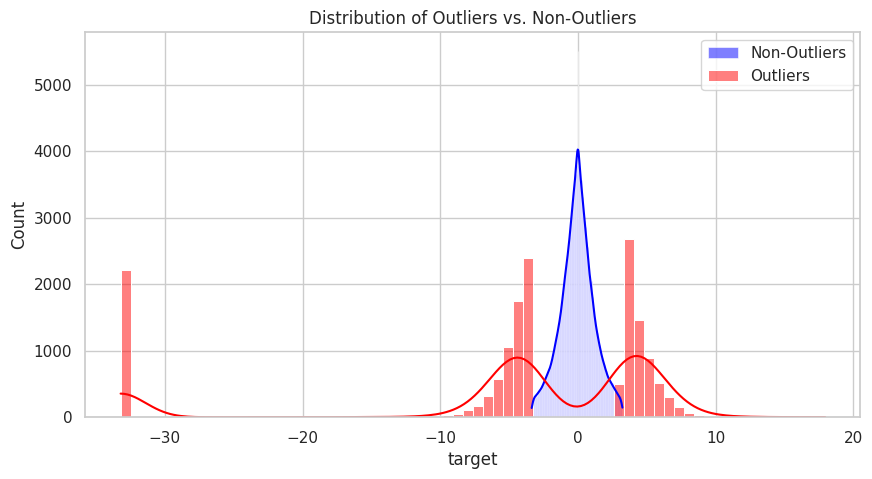

In [20]:
# Separate outliers and non-outliers
outliers = df.loc[df.index.isin(outlier_dict['target'])]
non_outliers = df.loc[~df.index.isin(outlier_dict['target'])]

# Plot histograms
plt.figure(figsize=(10, 5))
sns.histplot(non_outliers['target'], color="blue", label="Non-Outliers", kde=True)
sns.histplot(outliers['target'], color="red", label="Outliers", kde=True)
plt.legend()
plt.title("Distribution of Outliers vs. Non-Outliers")
plt.show();

As we can see there are some points that are far away from all the points. These have target below -30. Since, these points constitute 1.09% of data, these cannot be labelled as outliers. So, lets just call them rare data points.



### <font color='blue'>Analyzing Categorical Features for Outliers vs. Non-Outliers</b>###


Feature: feature_1
----------------------------------------
Outliers Distribution:
 feature_1
3   0.411
2   0.237
5   0.201
4   0.100
1   0.052
Name: proportion, dtype: float64

Non-Outliers Distribution:
 feature_1
3   0.361
2   0.280
5   0.201
4   0.098
1   0.060
Name: proportion, dtype: float64


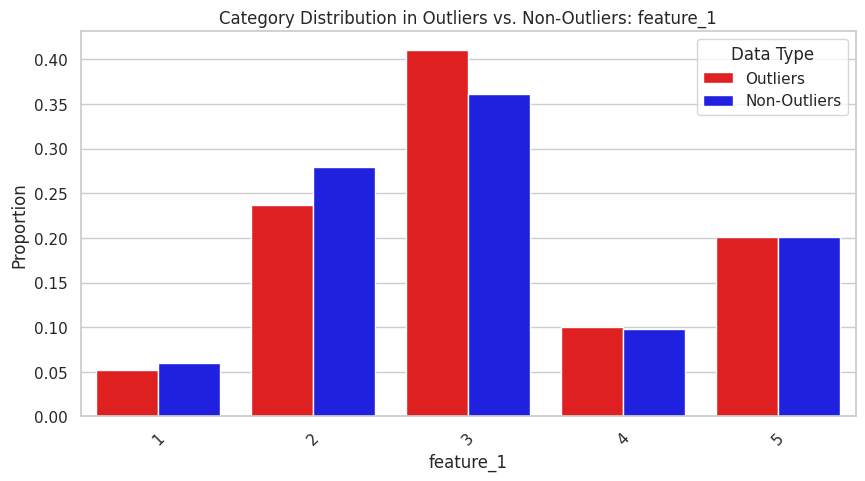


Feature: feature_2
----------------------------------------
Outliers Distribution:
 feature_2
1   0.416
2   0.392
3   0.192
Name: proportion, dtype: float64

Non-Outliers Distribution:
 feature_2
1   0.444
2   0.369
3   0.187
Name: proportion, dtype: float64


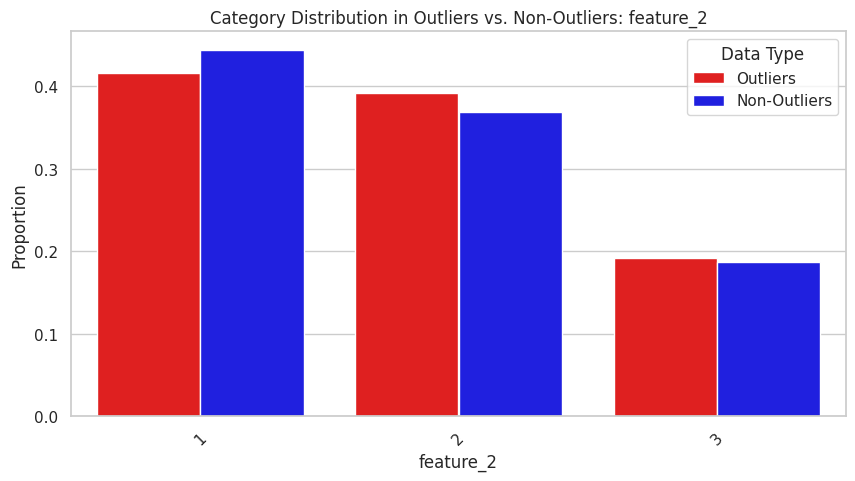


Feature: feature_3
----------------------------------------
Outliers Distribution:
 feature_3
1   0.611
0   0.389
Name: proportion, dtype: float64

Non-Outliers Distribution:
 feature_3
1   0.562
0   0.438
Name: proportion, dtype: float64


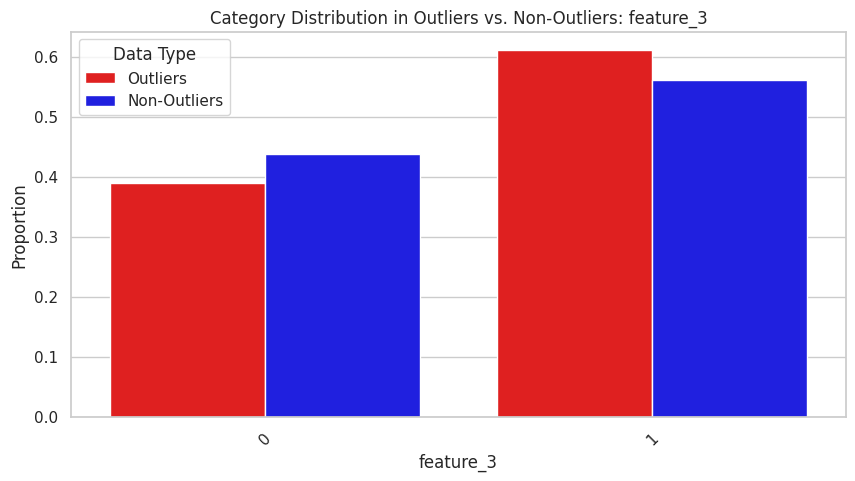

In [21]:
cat_features=['feature_1', 'feature_2', 'feature_3']

def analyze_categorical_outliers(df, categorical_cols, outliers_index):
    for col in cat_features:
        print(f"\nFeature: {col}")
        print("-" * 40)

        # Count unique values for outliers vs. non-outliers
        outliers_counts = outliers[col].value_counts(normalize=True)
        non_outliers_counts = non_outliers[col].value_counts(normalize=True)

        print("Outliers Distribution:\n", outliers_counts)
        print("\nNon-Outliers Distribution:\n", non_outliers_counts)

        # Visualization
        combined = pd.DataFrame({
            'Category': outliers_counts.index.tolist() + non_outliers_counts.index.tolist(),
            'Proportion': outliers_counts.tolist() + non_outliers_counts.tolist(),
            'Type': ['Outliers'] * len(outliers_counts) + ['Non-Outliers'] * len(non_outliers_counts)
        })

        # Plot side-by-side bar chart
        plt.figure(figsize=(10, 5))
        palette = {"Outliers": "red", "Non-Outliers": "blue"}
        sns.barplot(data=combined, x='Category', y='Proportion', hue='Type', palette=palette)
        plt.title(f"Category Distribution in Outliers vs. Non-Outliers: {col}")
        plt.ylabel("Proportion")
        plt.xlabel(col)
        plt.legend(title="Data Type")
        plt.xticks(rotation=45)
        plt.show()


outliers_index = outlier_dict['target']  # Indices of detected outliers
analyze_categorical_outliers(df, cat_features, outliers_index)

- Since feature_1 = 3 appears more frequently in outliers, it might indicate an issue related to this category.


# <font color='red'>4- ***Feature Engineering***###

In [22]:
df["first_active_month"] = pd.to_datetime(df["first_active_month"],format='%Y-%M')
reference_date = pd.to_datetime('today')
# Extract the month, year, day, weekday
df["month"] = df["first_active_month"].dt.month
df["year"] = df["first_active_month"].dt.year
df["week"] = df["first_active_month"].dt.isocalendar().week  # Corrected method
df["dayofweek"] = df["first_active_month"].dt.dayofweek
df["days_since_joining"] = (reference_date - df["first_active_month"]).dt.days

# Compute the difference in months from today (hardcoded)
df["months_since_joining"] = (12*(reference_date.year - df["first_active_month"].dt.year)  + (
    reference_date.month - df["first_active_month"].dt.month))

# Drop the original 'first_active_month' column
df.drop(columns=["first_active_month"], inplace=True)

# Display the first few rows
df.head()

,card_id,feature_1,feature_2,feature_3,target,month,year,week,dayofweek,days_since_joining,months_since_joining
0,C_ID_92a2005557,5,2,1,-0.820,1,2017,52,6,3032,99
1,C_ID_3d0044924f,4,1,0,0.393,1,2017,52,6,3032,99
2,C_ID_d639edf6cd,2,2,0,0.688,1,2016,53,4,3398,111
3,C_ID_186d6a6901,4,3,0,0.142,1,2017,52,6,3032,99
4,C_ID_cdbd2c0db2,1,3,0,-0.160,1,2017,52,6,3032,99


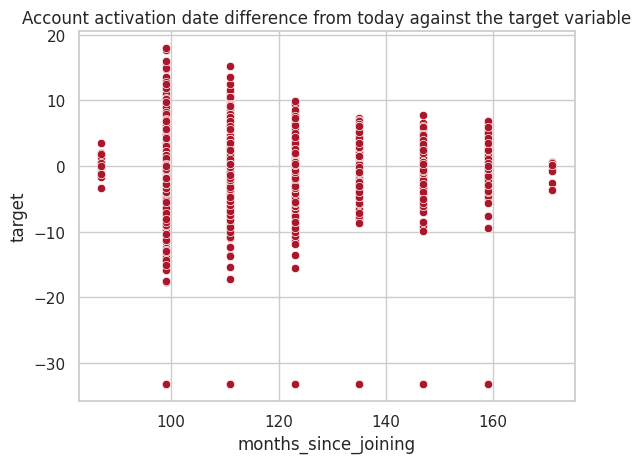

In [23]:
sns.scatterplot(data=df,x='months_since_joining', y='target')
plt.title('Account activation date difference from today against the target variable')
plt.show();

- The most recent have higher loyalty scores.
- More number of recent users compared to long time users.

### <font color='blue'>Aggregation Over Categorical Features</b>###

In [24]:
df['feature_sum'] = df[cat_features].sum(axis=1)
df['feature_mean'] = df[cat_features].mean(axis=1)
df['feature_median'] = df[cat_features].median(axis=1)
df['feature_max'] = df[cat_features].max(axis=1)
df['feature_min'] = df[cat_features].min(axis=1)
df['feature_std'] = df[cat_features].std(axis=1)
df['feature_range'] = df['feature_max'] - df['feature_min']

# Are users with higher feature sums also long-term members?
df['feature_sum_x_days'] = df['feature_sum'] * df['months_since_joining']

# Months-based interactions :How individual categorical feature values vary with account age
df_months = df['months_since_joining']
for f in cat_features:
    df[f'months_{f}'] = df_months * df[f]
    df[f'months_{f}_ratio'] = df[f] / (df_months.replace(0, np.nan))  # Avoid division by zero

# Replace NaNs or infinite values in ratios
df.replace([np.inf, -np.inf], 0, inplace=True)
df.fillna(0, inplace=True)

In [25]:
df.head()

,card_id,feature_1,feature_2,feature_3,target,month,year,week,dayofweek,days_since_joining,months_since_joining,feature_sum,feature_mean,feature_median,feature_max,feature_min,feature_std,feature_range,feature_sum_x_days,months_feature_1,months_feature_1_ratio,months_feature_2,months_feature_2_ratio,months_feature_3,months_feature_3_ratio
0,C_ID_92a2005557,5,2,1,-0.820,1,2017,52,6,3032,99,8,2.667,2.000,5,1,2.082,4,792,495,0.051,198,0.020,99,0.010
1,C_ID_3d0044924f,4,1,0,0.393,1,2017,52,6,3032,99,5,1.667,1.000,4,0,2.082,4,495,396,0.040,99,0.010,0,0.000
2,C_ID_d639edf6cd,2,2,0,0.688,1,2016,53,4,3398,111,4,1.333,2.000,2,0,1.155,2,444,222,0.018,222,0.018,0,0.000
3,C_ID_186d6a6901,4,3,0,0.142,1,2017,52,6,3032,99,7,2.333,3.000,4,0,2.082,4,693,396,0.040,297,0.030,0,0.000
4,C_ID_cdbd2c0db2,1,3,0,-0.160,1,2017,52,6,3032,99,4,1.333,1.000,3,0,1.528,3,396,99,0.010,297,0.030,0,0.000


In [26]:
df.shape

(201917, 25)

In [ ]:
df.to_csv('/content/drive/MyDrive/Final_Project_ELO_Merchant/final_train.csv', index=False)
print("train_aggregation saved")


train_aggregation saved
